# Classification of leaves with SVM

In [13]:
import numpy as np
import pandas as pd
import os
import string
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score,cross_val_predict
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib inline
import mahotas as mt

In [14]:
data = pd.read_csv("Leaf.csv")

In [15]:
 classes=[1001,1059,1060,1122,1552,1616,1123,1194,1195,1267,1268,1323,1324,1385,1386,1437,1497,1551,1438,1496,2001,2050,2051,2113,2114,2165,2166,2230,2231,2290,2291,2346,2347,2423,2424,2485,2486,2546,2547,2612,2616,2675,3001,3055,3056,3110,3111,3175,3176,3229,3230,3281,3282,3334,3335,3389,3390,3446,3447,3510,3511,3563,3566,3621]

In [16]:
target_list = []
for file in os.listdir("Leaves"):
    target_num = int(file.split(".")[0])
    flag = 0
    i = 0 
    for i in range(0,len(classes),2):
        if((target_num >= classes[i]) and (target_num <= classes[i+1])):
            flag = 1
            break
    if(flag==1):
        target = int((i/2))
        target_list.append(target)
X = data.iloc[:,1:]
y = np.array(target_list)
y        

array([ 0,  0,  0, ..., 31, 31, 31])

In [17]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 152)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state = 0)

In [18]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [38]:
svm_model=svm.SVC(kernel='linear',C=1).fit(X_train,y_train)
svm_predictions=svm_model.predict(X_test)
accuracy=svm_model.score(X_test,y_test)
cm=metrics.confusion_matrix(y_test,svm_predictions)
print(svm_model)
print(svm_predictions)
print(accuracy)
print(cm)
#clf = svm.SVC(kernel='linear',C=1)
#clf.fit(X_train,y_train)
#y_pred = clf.predict(X_test)

#print(metrics.classification_report(y_test, y_pred))


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[29 22  0  3  2 19 16 16  1  9  3 16  5 30  2 19  2  4 24  0 13 30  6 19
 17 15  8  9  8  3  1 24 25 28 16 12 27 24 25 30 28  7 31 16 22  9 10 20
 15 20  9 16  4 28  9 18 17 12  5 27  6 21  3  3  0 30  5 25  0 25 17  2
 26 17 16 18 15 16 14 18 17 19 25 10  1 28 23  6 22 21  0 14 16 14 23  5
 23 26  4 23  0  2 30  5 18 30 30 10 23 15 29 10  4 18  8  3 18 20  4  5
 23  8 13 26  2 24 31 30 28 14  7 25 11 30  3 10  4 14 29  6  0  0 16 11
 23  2  9 14 13 11  4 12 11  0  1 17  0  8  5  0  4  2 18 21  6 11 19 16
  0  2  9 29 30 17 21 22  0 23 10 23 27 19 28 17 19  2 11 18  2  3 11 20
 15  1 27 23 25  0 21  6 10  1 23 14 24  5 26  3  5 24 18  2 16 22  0 10
 28 17  0  6  5 20 26 23 27 29 16  3  8  3 24 28 29  2 31 26 20 17  6  6
 18  9  7 18 19 25 21  2 27 24 12  0 10  7  

In [39]:
metrics.accuracy_score(y_test, svm_predictions)
#scores=cross_val_score(svm_model,X,y,cv=6)
#print(scores)

0.8789625360230547

In [40]:
parameters = [{'kernel': ['rbf'],
               'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
               'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
             ]
svm_clf = GridSearchCV(svm.SVC(decision_function_shape='ovr'), parameters, cv=5)
svm_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5], 'C': [1, 10, 100, 1000]}, {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [41]:
svm_clf.best_params_
y_pred_svm = svm_clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred_svm)

0.9106628242074928

In [42]:
def bg_sub(filename):
    main_img = cv2.imread(os.path.join("Test",filename))
    img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(img, (1600, 1200))
    size_y,size_x,_ = img.shape
    gs = cv2.cvtColor(resized_image,cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gs, (55,55),0)
    ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((50,50),np.uint8)
    closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
    
    ret_image, contours, hierarchy = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    contains = []
    y_ri,x_ri, _ = resized_image.shape
    for cc in contours:
        yn = cv2.pointPolygonTest(cc,(x_ri//2,y_ri//2),False)
        contains.append(yn)

    val = [contains.index(temp) for temp in contains if temp>0]
    index = val[0]
    
    black_img = np.empty([1200,1600,3],dtype=np.uint8)
    black_img.fill(0)
    
    cnt = contours[index]
    mask = cv2.drawContours(black_img, [cnt] , 0, (255,255,255), -1)
    
    maskedImg = cv2.bitwise_and(resized_image, mask)
    white_pix = [255,255,255]
    black_pix = [0,0,0]
    
    final_img = maskedImg
    h,w,channels = final_img.shape
    for x in range(0,w):
        for y in range(0,h):
            channels_xy = final_img[y,x]
            if all(channels_xy == black_pix):
                final_img[y,x] = white_pix
    
    return final_img

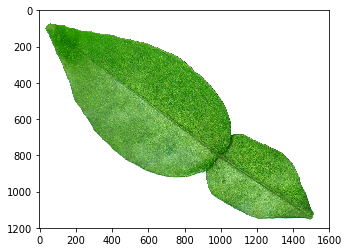

In [904]:
filename = '3614.jpg' 
bg_rem_img = bg_sub(filename)
plt.imshow(bg_rem_img,cmap='Greys_r')
plt.show()
        

In [905]:
def feature_extract(img):
    names = ['area','perimeter','pysiological_length','pysiological_width','aspect_ratio','rectangularity','circularity',
             'mean_r','mean_g','mean_b','stddev_r','stddev_g','stddev_b',
             'contrast','correlation','inverse_difference_moments','entropy'
            ]
    df = pd.DataFrame([], columns=names)

    #Preprocessing
    gs = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gs, (25,25),0)
    ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((50,50),np.uint8)
    closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)

    #Shape features
    image, contours, _ = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    M = cv2.moments(cnt)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt,True)
    x,y,w,h = cv2.boundingRect(cnt)
    aspect_ratio = float(w)/h
    rectangularity = w*h/area
    circularity = ((perimeter)**2)/area

    #Color features
    red_channel = img[:,:,0]
    green_channel = img[:,:,1]
    blue_channel = img[:,:,2]
    blue_channel[blue_channel == 255] = 0
    green_channel[green_channel == 255] = 0
    red_channel[red_channel == 255] = 0

    red_mean = np.mean(red_channel)
    green_mean = np.mean(green_channel)
    blue_mean = np.mean(blue_channel)

    red_std = np.std(red_channel)
    green_std = np.std(green_channel)
    blue_std = np.std(blue_channel)

    #Texture features
    textures = mt.features.haralick(gs)
    ht_mean = textures.mean(axis=0)
    contrast = ht_mean[1]
    correlation = ht_mean[2]
    inverse_diff_moments = ht_mean[4]
    entropy = ht_mean[8]

    vector = [area,perimeter,w,h,aspect_ratio,rectangularity,circularity,
              red_mean,green_mean,blue_mean,red_std,green_std,blue_std,
              contrast,correlation,inverse_diff_moments,entropy
             ]

    df_temp = pd.DataFrame([vector],columns=names)
    df = df.append(df_temp)
    
    return df

In [906]:
features_of_img = feature_extract(bg_rem_img)

features_of_img=sc_X.transform(features_of_img)

In [907]:
y_pred_img = svm_clf.predict(features_of_img)
y_pred_img

array([31])

In [908]:
species = ['pubescent bamboo','Chinese horse chestnut','Anhui Barberry',
                'Chinese redbud','true indigo','Japanese maple','Nanmu',' castor aralia', 
                'Chinese cinnamon','goldenrain tree','Big-fruited Holly','Japanese cheesewood',
                'wintersweet','camphortree','Japan Arrowwood','sweet osmanthus','deodar','ginkgo, maidenhair tree',
                'Crape myrtle, Crepe myrtle','oleander','yew plum pine','Japanese Flowering Cherry','Glossy Privet',
                'Chinese Toon','peach','Ford Woodlotus','trident maple','Beales barberry','southern magnolia',
                'Canadian poplar','Chinese tulip tree','tangerine'
               ]
species[y_pred_img[0]]

'tangerine'